## Ансамбли. Бустинг

### ЗАДАНИЕ I. ДОПОЛНИТЕЛЬНОЕ

Дано: набор данных из системы поискового антиспама.

Требуется: сравнить классификаторы, основанные на алгоритмических композициях, с классическими алгоритмами классификации и нейросетями.

1. Скачать данные и запустить шаблон кода на python:

```
$ python compos.py -h
$ python compos.py -tr spam.train.txt -te spam.test.txt
```
2. Подобрать параметры трёх алгоритмических композиций, чтобы они превосходили по качеству SVM, логистическую регрессию и двуслойный персептрон.

3. Построить графики качества классификации в зависимости от числа базовых моделей.

In [1]:
!python compos.py -h
!python compos.py -tr spam.train.txt -te spam.test.txt

usage: compos.py [-h] [-tr TRAIN] [-te TEST] [-t TREES] [-fp FEATURES_PERCENT]

Random Forest Tutorial

optional arguments:
  -h, --help            show this help message and exit
  -tr TRAIN, --train TRAIN
                        Train file name
  -te TEST, --test TEST
                        Test file name
  -t TREES, --trees TREES
                        Number of trees in random forest
  -fp FEATURES_PERCENT, --features_percent FEATURES_PERCENT
                        Percent of features in each tree
Build random forest classifier...
Build adaboost classifier...
Build gbm classifier...
Build svm classifier...
Random Forest :
             precision    recall  f1-score   support

        0.0    0.57718   0.75406   0.65387      2033
        1.0    0.93243   0.86003   0.89477      8023

avg / total    0.86061   0.83860   0.84607     10056
final score    0.75481   0.80704   0.77432     10056

AdaBoost :
             precision    recall  f1-score   support

        0.0    0.92398   0.424

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression

In [9]:
train_data = np.loadtxt("spam.train.txt")
test_data  = np.loadtxt("spam.test.txt")

X_train, y_train = train_data[0::, 1::], train_data[0::, 0]
X_test, y_test = test_data[0::, 1::], test_data[0::, 0]

In [4]:
X_train.shape

(7093, 102)

In [5]:
svm_classifier = svm.SVC()
svm_classifier.fit(X_train, y_train)
y_pred = svm_classifier.predict(X_test)
f1_score(y_test, y_pred)

0.9585241566148487

In [6]:
logreg_classifier = LogisticRegression()
logreg_classifier.fit(X_train, y_train)
y_pred = logreg_classifier.predict(X_test)
f1_score(y_test, y_pred)

/Users/anastasiabogatenkova/miniconda3/envs/sphere/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.9354754098360656

In [48]:
import torch
from torch.nn import MSELoss, Linear, Sigmoid, Module

class Net(Module):
    def __init__(self, activation=Sigmoid(), latent_size=100):
        super().__init__()
        self.fc1 = Linear(102, latent_size)
        self.fc2 = Linear(latent_size, 1)
        self.activation = activation
    def forward(self, x):
        return self.fc2(self.activation(self.fc1(x)))
    
def train(network, X_train, y_train, epochs=200, learning_rate=0.01, loss=MSELoss(), optim=torch.optim.Adam):
    optimizer = optim(network.parameters(), lr=learning_rate)
    for epoch in range(epochs):
        optimizer.zero_grad()
        y_pred = network(X_train)
        loss_value = loss(y_pred, y_train)
        loss_value.backward()
        optimizer.step()

In [49]:
perceptron = Net()
train(perceptron, torch.from_numpy(X_train).float(), torch.from_numpy(y_train[:,np.newaxis]).float())
y_pred = perceptron(torch.from_numpy(X_test).float())
f1_score(y_test[:,np.newaxis], (y_pred.detach().numpy() > 0.5).astype(int))

0.940163132137031

In [69]:
params = list(range(50, 1001, 50)) # n_estimators

def tune_n_estimators(clf, X_train, y_train):
    best_n_estimators = params[0]
    res_score = 0
    scores = []

    for n_estimators in params:
        clf = clf.set_params(**{'n_estimators': n_estimators})
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        score = f1_score(y_test, y_pred)
        scores.append(score)
        if score > res_score:
            best_n_estimators = n_estimators
            res_score = score
    return scores, res_score, best_n_estimators

def make_plot(scores, clf_name):
    plt.figure(figsize=(15, 5))
    plt.title('Parameters tuning for ' + clf_name)
    plt.xlabel('n_estimators')
    plt.ylabel('F1-score')
    plt.tick_params(axis='x', labelrotation=90)
    plt.plot(params, scores)

F1-score=0.9679426141052497, n_estimators=900


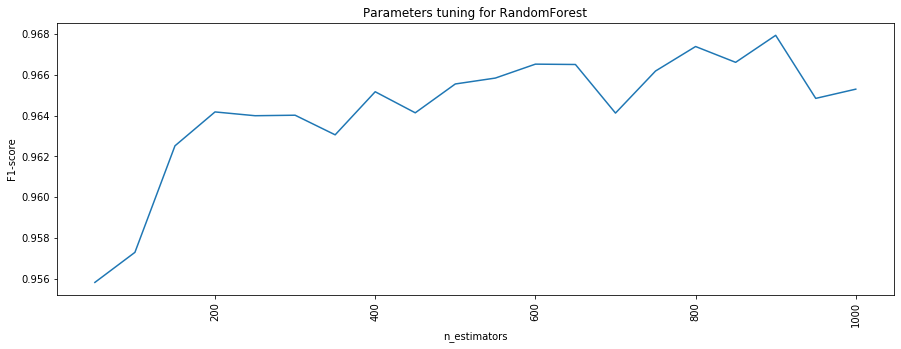

In [70]:
forest = RandomForestClassifier()
scores, res_score, best_n_estimators = tune_n_estimators(forest, X_train, y_train)
print(f'F1-score={res_score}, n_estimators={best_n_estimators}')
make_plot(scores, 'RandomForest')

F1-score=0.9599457727384767, n_estimators=150


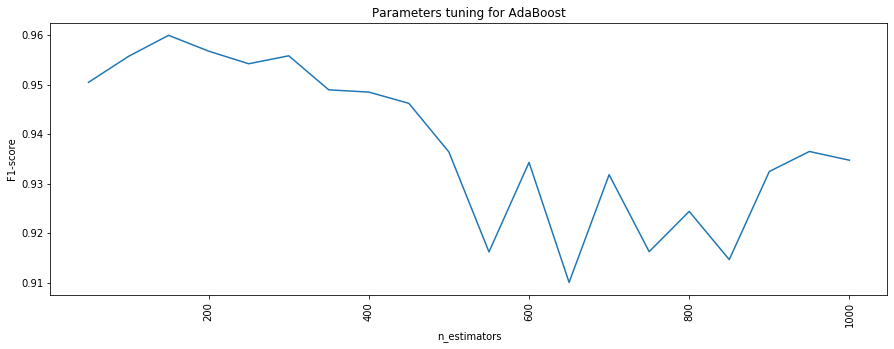

In [71]:
adaboost_classifier = AdaBoostClassifier()
scores, res_score, best_n_estimators = tune_n_estimators(adaboost_classifier, X_train, y_train)
print(f'F1-score={res_score}, n_estimators={best_n_estimators}')
make_plot(scores, 'AdaBoost')

F1-score=0.975473107569721, n_estimators=250


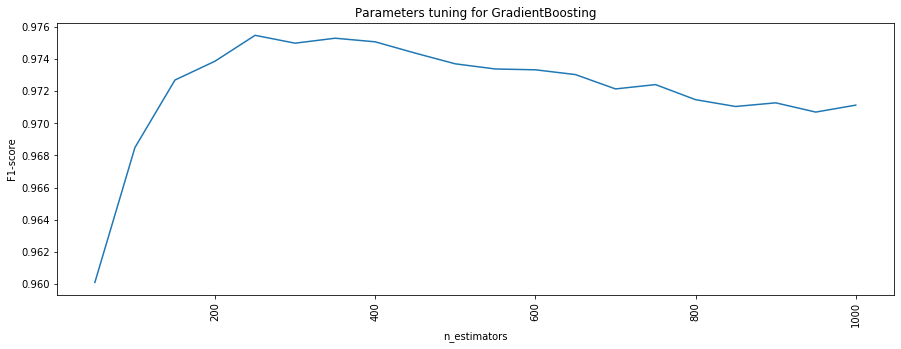

In [72]:
gbm_classifier = GradientBoostingClassifier()
scores, res_score, best_n_estimators = tune_n_estimators(gbm_classifier, X_train, y_train)
print(f'F1-score={res_score}, n_estimators={best_n_estimators}')
make_plot(scores, 'GradientBoosting')

### ЗАДАНИЕ II. ОСНОВНОЕ

Что необходимо сделать: реализовать один из алгоритмов машинного обучения, являющегося композицией алгоритмов.

In [8]:
def ComputeMyTaskNumber(your_name):
    return 1 + hash(your_name) % 21
ComputeMyTaskNumber('Bogatenkova_Anastasiya')

7

Вариант 7: Реализация алгоритма BagBoo. В качестве базового алгоритма использовать алгоритм градиентного бустинга с логистической функцией потерь.

In [10]:
import numpy as np
from scipy import stats
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

In [11]:
class DecisionTree:
    
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1):
        self.tree = dict()
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.get_feature_ids = self.__get_feature_ids_N

    def __get_feature_ids_N(self, n_feature):
        return np.arange(n_feature)
    
    @staticmethod
    def _sort_samples(X, y):
        sorted_idx = X.argsort(axis=0)
        return np.sort(X, axis=0), y[sorted_idx]
    
    @staticmethod
    def _div_samples(X, y, feature_id, threshold):
        left_mask = X[:, feature_id] <= threshold
        right_mask = ~left_mask
        return X[left_mask], X[right_mask], y[left_mask], y[right_mask]

    def __fit_node(self, X, y, node_id, depth):
        if (X.shape[0] < self.min_samples_split) or (depth == self.max_depth):
            self.tree[node_id] = self.LEAF_TYPE, np.mean(y)
            return

        sortX, sortY = DecisionTree._sort_samples(X, y)

        cumsumY2 = np.cumsum(sortY ** 2, axis=0)
        cumsumRevY2 = np.cumsum(sortY[::-1] ** 2, axis=0)[::-1]

        cumsumY = np.cumsum(sortY, axis=0)
        cumsumRevY = np.cumsum(sortY[::-1], axis=0)[::-1]

        lenArray = np.array(range(1, cumsumY.shape[0] + 1)).reshape(-1, 1)
        left = cumsumY2 - cumsumY ** 2 / lenArray
        right = cumsumRevY2 - cumsumRevY ** 2 / lenArray[::-1]

        mse = left
        mse[:-1] += right[1:]
        
        bad_features = np.where((np.max(X, axis=0) - np.min(X, axis=0)) < 1e-3)[0]
        mse[:, bad_features] = np.nan
        mse[np.isclose(sortX, np.roll(sortX, shift=-1, axis=0))] = np.nan
        
        try:
            argmin = np.nanargmin(mse)
        except ValueError:
            self.tree[node_id] = self.LEAF_TYPE, np.mean(y)
            return
        
        idx = argmin // mse.shape[1]
        feature_id = argmin - idx * mse.shape[1]
        
        threshold = sortX[idx, feature_id]
        Xleft, Xright, Yleft, Yright = self._div_samples(X, y, feature_id, threshold)

        if Xleft.shape[0] < self.min_samples_leaf or Xright.shape[0] < self.min_samples_leaf:
            self.tree[node_id] = self.LEAF_TYPE, np.mean(y)
        else:
            self.tree[node_id] = self.NON_LEAF_TYPE, feature_id, threshold
            
            self.__fit_node(Xleft, Yleft, 2 * node_id + 1, depth + 1)
            self.__fit_node(Xright, Yright, 2 * node_id + 2, depth + 1)

    def fit(self, X, y):
        self.features = self.get_feature_ids(X.shape[1])
        self.__fit_node(X[:, self.features], y, 0, 0)
        return self

    def __predict(self, X, node_id):
        node = self.tree[node_id]
        answer = np.zeros(X.shape[0])
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            left_idx = np.where(X[:, feature_id] <= threshold)
            right_idx = np.where(X[:, feature_id] > threshold)

            answer[left_idx] = self.__predict(X[left_idx], 2 * node_id + 1)
            answer[right_idx] = self.__predict(X[right_idx], 2 * node_id + 2)
            return answer
        return np.array([node[1]] * X.shape[0])
            
    def predict(self, X):
        X = X[:, self.features]
        answer = self.__predict(X, 0)
        return answer

In [12]:
myclf = DecisionTree(max_depth=7)
%time myclf.fit(X_train, y_train)

CPU times: user 664 ms, sys: 152 ms, total: 817 ms
Wall time: 823 ms


In [13]:
clf = DecisionTreeRegressor(max_depth=7)
%time clf.fit(X_train, y_train)

CPU times: user 166 ms, sys: 1.54 ms, total: 168 ms
Wall time: 167 ms


DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=7,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [14]:
y_pred = myclf.predict(X_test)
mean_squared_error(y_test, y_pred)

0.15994301517451368

In [15]:
y_pred = clf.predict(X_test)
mean_squared_error(y_test, y_pred)

0.14878405733322733

### Two-class logistic regression and classification

In [91]:
class GradientBoosting:
    def __init__(self, learning_rate=0.95,
                 n_estimators=100,
                 max_depth=3,
                 base_estimator=DecisionTreeRegressor):

        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.base_estimator = base_estimator
        self.estimators = [None] * self.n_estimators
        self.weights = []
        self.train_score_ = []
        self.train_pred_ = []
        
    @staticmethod
    def _sigmoid(x):
        return 1 / (1 + np.exp(-x))

    @staticmethod
    def _loss(y_true, y_pred):
        p = y_pred.copy()
        p[np.where(p < 1e-5)] = 1e-6
        p[np.where((1 - p) < 1e-5)] = 0.999999
        return np.mean(- y_true * np.log(p) - (1 - y_true) * np.log(1 - p))

    @staticmethod
    def _negative_gradient(y_true, y_pred):
        # - y*log(sigma(x)) - (1-y)*log(1-sigma(x))
        # sigma(x)' = sigma(x) * (1 - sigma(x))
        # dL/dx = - y*sigma*(1-sigma)/sigma + (1-y)(1-sigma)/sigma*(1-sigma) = sigma(x) - y
        return  y_true - GradientBoosting._sigmoid(y_pred) 

    def _newton(self, y, a, h):
        # sigma(x) = 1 / (1 + exp(-(h+b*a)))
        # dx/db = (h+b*a)' = a
        # f = dL/db = a * (sigma(x) - y)
        # f' = (a * (sigma(x) - y))' = a * sigma(x)' * (h+b*a)' = a * sigma*(1-sigma) * a = a^2 * sigma*(1-sigma)
        b = 0
        while True:
            z = h + b * a
            f = np.sum(a * (self._sigmoid(z) - y))
            dfdb = np.sum(np.power(a, 2) * self._sigmoid(z) * (1 - self._sigmoid(z)))
            b = b - f / dfdb
            if np.abs(f) < 0.0005: 
                break
        return b
    
    def _get_class(self, p):
        return np.where(p < 0.5, 0, 1)

    def fit(self, X, y):
        y_pred = np.zeros(y.shape[0])
        for i in range(self.n_estimators):             
            gi = self._negative_gradient(y, y_pred)
            self.estimators[i] = self.base_estimator(max_depth=self.max_depth).fit(X, gi)
            y_pred_new = self.estimators[i].predict(X)
            weights = self._newton(y, y_pred_new, y_pred)
            self.weights.append(weights)
            y_pred = y_pred + self.learning_rate * y_pred_new * weights
            self.train_pred_.append(y_pred)
        return self

    def predict(self, X):
        predict = np.zeros(X.shape[0])
        for i, model in enumerate(self.estimators):
            predict = predict + self.learning_rate * model.predict(X) * self.weights[i]
        return self._get_class(self._sigmoid(predict))
     
    def staged_decision_function(self, X):
        predicts = []
        predict = np.zeros(X.shape[0])
        for i, model in enumerate(self.estimators):
            predict = predict + self.learning_rate * model.predict(X) * self.weights[i]
            predicts.append(self._sigmoid(predict))
        return predicts

In [101]:
N_ESTIMATORS = 600

In [102]:
myclf = GradientBoosting(n_estimators=N_ESTIMATORS)
myclf.fit(X_train, y_train)
y_pred = myclf.predict(X_test)
f1_score(y_test, y_pred)

0.8753861997940268

In [103]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(learning_rate=0.95, n_estimators=N_ESTIMATORS, max_depth=3)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
f1_score(y_test, y_pred)

0.9553156771683193

sklearn last train loss = 0.00017526802755241902
threshold 3% = 5.2580408265725705e-06
my last train loss = 8.253899013745461e-05


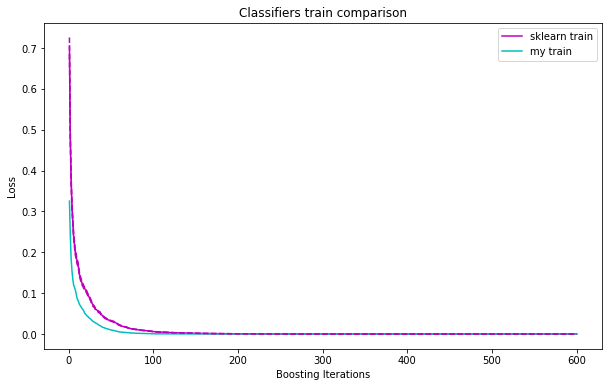

In [104]:
plt.figure(figsize=(10, 6))
plt.title('Classifiers train comparison')
train_score_ = [myclf._loss(y_train, myclf._sigmoid(y_pred)) for y_pred in myclf.train_pred_]
plt.plot(np.arange(N_ESTIMATORS) + 1, clf.train_score_, 'm-', label='sklearn train')
plt.plot(np.arange(N_ESTIMATORS) + 1, train_score_, 'c-', label='my train')
plt.plot(np.arange(N_ESTIMATORS) + 1,[x * 1.03 for x in clf.train_score_], 'm-', linestyle='--')
plt.plot(np.arange(N_ESTIMATORS) + 1,[x * 0.97 for x in clf.train_score_], 'm-', linestyle='--')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Loss')
print(f"sklearn last train loss = {clf.train_score_[-1]}")
print(f"threshold 3% = {0.03 * clf.train_score_[-1]}")
print(f"my last train loss = {train_score_[-1]}")

sklearn last test loss = 1.2233071964120705
threshold 3% = 0.036699215892362115
my last test loss = 1.5513632011485856


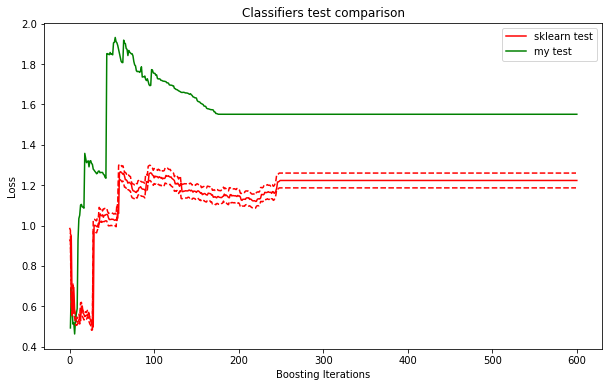

In [105]:
base_test_score = np.zeros(N_ESTIMATORS)
my_test_score = np.zeros(N_ESTIMATORS)
for i, y_pred in enumerate(clf.staged_decision_function(X_test)):
    base_test_score[i] = clf.loss_(y_test, y_pred) 
for i, y_pred in enumerate(myclf.staged_decision_function(X_test)):
    my_test_score[i] = myclf._loss(y_test, y_pred)

plt.figure(figsize=(10, 6))
plt.title('Classifiers test comparison')
plt.plot(np.arange(N_ESTIMATORS) + 1, base_test_score, 'r-', label='sklearn test')
plt.plot(np.arange(N_ESTIMATORS) + 1, my_test_score, 'g-', label='my test')
plt.plot([x * 1.03 for x in base_test_score], 'r-', linestyle='--')
plt.plot([x * 0.97 for x in base_test_score], 'r-', linestyle='--')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Loss')

print(f"sklearn last test loss = {base_test_score[-1]}")
print(f"threshold 3% = {0.03 * base_test_score[-1]}")
print(f"my last test loss = {my_test_score[-1]}")

In [98]:
class BagBoo:
    
    def __init__(self, n_estimators=10, max_samples=1.0, max_features=1.0):
        """
        max_samples: float, proportion of samples to draw from X to train each base estimator
        max_features: float, proportion of features to draw from X to train each base estimator
        """
        self.n_estimators = n_estimators
        self.estimators = [GradientBoosting() for i in range(self.n_estimators)]
        self.max_samples = max_samples
        self.max_features = max_features
        self.features_ids_list = []
    
    def fit(self, X_train, y_train):
        samples_num = int(self.max_samples * X_train.shape[0])
        features_num = int(self.max_features * X_train.shape[1])
        for estimator in self.estimators:
            samples_ids = np.random.choice(X_train.shape[0], samples_num, replace=True)
            features_ids = np.random.choice(X_train.shape[1], features_num, replace=False)
            self.features_ids_list.append(features_ids)
            estimator.fit(X_train[samples_ids][:, features_ids], y_train[samples_ids])
        
    def predict(self, X_test):
        predictions = []
        for i in range(self.n_estimators):
            predictions.append(self.estimators[i].predict(X_test[:,self.features_ids_list[i]]))
        return stats.mode(predictions)[0][0]

In [99]:
bagboo = BagBoo(10, 0.7)
bagboo.fit(X_train, y_train)
y_pred = bagboo.predict(X_test)
f1_score(y_test, y_pred)

0.9639746883027379

In [100]:
from sklearn.ensemble import BaggingClassifier

bagboo_sklearn = BaggingClassifier(base_estimator=GradientBoostingClassifier(loss='deviance'), 
                n_estimators=10, 
                max_samples=0.7)
bagboo_sklearn.fit(X_train, y_train)
y_pred = bagboo_sklearn.predict(X_test)
f1_score(y_test, y_pred)

0.9772995833074197